# Proton NMR - Technical

## Imports and Definitions

In [1]:
import sys

import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import cm
from glob import glob
from scipy.optimize import curve_fit, minimize
from allantools import oadev

# define the plot style for a dark presentation
plotStyle = {'axes.titlecolor':'white', 
             'axes.edgecolor':'white', 
             'xtick.color':'white', 
             'ytick.color':'white', 
             'figure.facecolor':'none', 
             'axes.labelcolor':'white'}

paperStyle = {'font.size':'12', 
              'legend.fontsize':'11', 
              'legend.labelspacing':'0.2'}

In [8]:
%load_ext autoreload
%autoreload 2

from nmrLib import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## NMR Signal

sampling interval:	7.8125 us


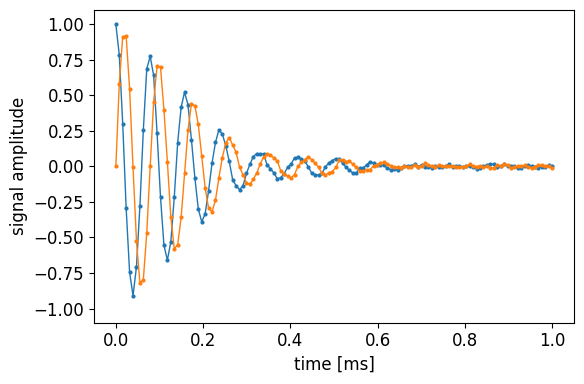

In [19]:
file = 'data/nmrSignal_reference.txt'

# spectral width in [Hz]
specWidth = 128e3

# sampling interval in [s]
tdwell = 1/specWidth
print('sampling interval:\t{} us'.format(1e6*tdwell))

# load the signal from the data file
sig = pd.read_csv(file, skiprows=12)
sig = (np.asarray(sig['[DATA]'][::2]) + 1.j*np.asarray(sig['[DATA]'][1::2]))

# create the time array
time = np.linspace(0, len(sig)*tdwell, len(sig))

# manually correct the phase of the signal
# shift by 20°
phase = 20
sig = sig * np.exp(-1.j*np.pi*phase/180)

# normalize the signal
sig = sig/sig.max()


#popt = (np.abs(sig).max(), 1e-4, 0)
#popt, pcov = curve_fit(relaxationTime, time, np.abs(sig), p0=popt)
#perr = np.sqrt(np.diag(pcov))
#print(popt[1]*1e6, perr[1]*1e6)

with plt.rc_context(paperStyle):
    
    fig, ax = plt.subplots()
    ax.plot(time*1e3, sig.real, 'C0.-', ms=4, lw=1)
    ax.plot(time*1e3, sig.imag, 'C1.-', ms=4, lw=1)
    ax.set(xlabel='time [ms]', ylabel='signal amplitude', ylim=(-1.1, 1.1))
    fig.set(dpi=100)
    fig.tight_layout()
    plt.show()

## NMR Spectrum

12775.221710902997 251
reduced chi-squared: 50.90



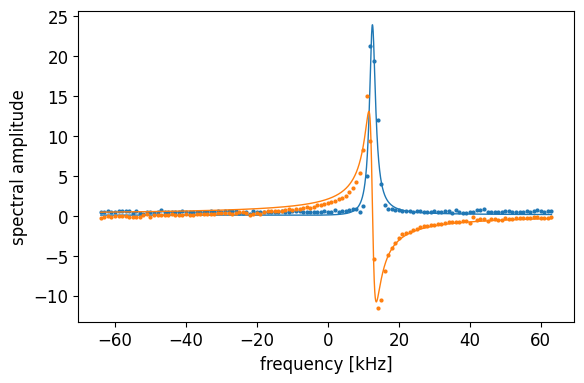

In [22]:
freq = np.fft.fftshift(np.fft.fftfreq(len(sig), d=tdwell))
spec = np.fft.fftshift(np.fft.fft(sig, n=len(sig), norm=None))
noise = spec[:len(spec)//2].real.std()
idx_max = 76
popt = (freq[idx_max],1e3*spec[idx_max].real,0.001,0,0)

popt, pcov = curve_fit(lorentzFitFct, np.hstack([freq,freq]), np.hstack([spec.real, spec.imag]), sigma=noise*np.ones(2*len(spec)), absolute_sigma=True, p0=popt, maxfev=100000)
perr = np.sqrt(np.diag(pcov))
chi2 = np.sum((np.hstack([spec.real, spec.imag])-lorentzFitFct(np.hstack([freq,freq]), *popt))**2 / (noise*np.ones(2*len(spec)))**2)
chi2_r = chi2 / (2*len(spec) - len(popt))

print(chi2, (2*len(spec) - len(popt)))
print('reduced chi-squared: {:.2f}\n'.format(chi2_r))

freqFit = np.linspace(freq.min(), freq.max(), 10001)

with plt.rc_context(paperStyle):
    
    fig, ax = plt.subplots()
    ax.plot(freq/1e3, spec.real, 'C0.', ms=4)
    ax.plot(freqFit/1e3, lorentzFct(freqFit, *popt).real, 'C0-', lw=1)    
    ax.plot(freq/1e3, spec.imag, 'C1.', ms=4)
    ax.plot(freqFit/1e3, lorentzFct(freqFit, *popt).imag, 'C1-', lw=1)
    ax.set(xlabel='frequency [kHz]', ylabel='spectral amplitude')
    fig.set(dpi=100)
    fig.tight_layout()
    plt.show()